# Homework 2: Multiwavelength Galactic Structure Part I

## Q1 and Q3:
These are found in calculus.py, matrix.py. In addition, you will find units tests for both in the tests/ directory.

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *
from matplotlib import rc

import astropy.units as un
from astropy import constants as const

import sys
sys.path.append("../HW1/")
from interpolation import linear_interpolator
from calculus import derivative, integrate
from matrix import Matrix, make_matrix

In [2]:
# Make more readable plots
rc('text',usetex=True)
rc('font',**{'size':18})
rc('xtick',**{'labelsize':18})
rc('ytick',**{'labelsize':18})
rc('axes',**{'labelsize':24,'titlesize':24})

## Q2: 
Using your chosen parameters of $c$, $v_{200}$, and $r_{200}$, numerically determine the mass enclosed $M_{\rm enc}(r)$ (and plot), the total mass of the dark matter halo $M$, and then also $M(r)$, the amount of mass in
a little shell around $r \pm \Delta r$ (i.e., what does the mass profile look like?), and $dM(r)/dr$. Compare this by repeating, holding $c$ fixed and changing $v_{200}$. Again compare the first by repeating, holding $v_{200}$ fixed and changing $c$. Feel free to use your previous tools from last time if you find that you need to (though I don't think you should); in the future you’ll be able to use built-in functions for those.

For simplicity, I will only solve for the form given in the problem, with $c$ = 15, $v_{200}$ = 160 km/s, and $r_{200}$ = 230 kpc. These were originally calculated the other way around from $M_{200}$ and 200 times the critical density of the Universe, $\rho_{\rm crit}$.

In [3]:
H0 = 70.0*un.km/un.s/un.Mpc
rho_crit = (3*H0**2/(8*np.pi*const.G)).to(un.g/un.cm**3) #matches above
rho_0 = 200*rho_crit

M_200 = 1.4e12*un.Msun #https://arxiv.org/pdf/1501.01788.pdf
r_200 = (M_200/((4*np.pi/3) * 200*rho_crit.to(un.Msun/un.kpc**3)))**(1.0/3)
v_200 = np.sqrt(const.G*M_200/r_200).to(un.km/un.s)

print(M_200, r_200, v_200)

c = 15.0

1400000000000.0 solMass 230.76202860993436 kpc 161.53342002695413 km / s


Define $v_c$ function from

$$\left[\frac{v_c(r)}{v_{200}}\right]^2 = \frac{1}{x} \frac{\ln(1+cx) - \frac{cx}{1+cx}}{\ln(1+c)-\frac{c}{1+c}}$$

where $c$ is a dimensionless "concentration" factor, $v_{200}$ is the velocity at a radius of $r_{200}$, where the density reaches 200 times the critical density of the Universe, and $x \equiv r/r_{200}$.

In [4]:
def v_c(r, c, r_200, v_200):
    """
    Returns the circular velocity given the
    concentration factor c and the velocity v_200
    at a radius r_200
    
    Parameters
    ==========
    r : float
        radius
    c : float
        concentration factor
    r_200 : float
        "Virial radius" where \rho = 200\rho_crit
    v_200 : float
        Velocity at r_200
        
    Returns
    =======
    v_c : float
        The circular velocity
    """
    x = r/r_200
    cx = c*x
    numer = np.log(1+cx) - cx/(1+cx)
    denom = x*(np.log(1+c) - c/(1+c))
    return v_200* np.sqrt(numer/denom)

Make plot to show $v_c$ vs $r$ (in the assignment, `rs` only goes to 300)

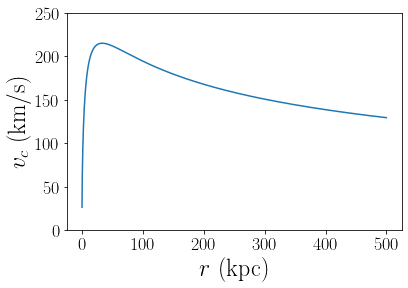

In [5]:
rs = np.arange(0.1, 500, 0.1)
vs = np.vectorize(v_c)(rs, c, r_200.value, v_200.value)

plot(rs, vs)
ylim(0, 250)
xlabel(r'$r~\mathrm{(kpc)}$')
ylabel(r'$v_c~(\mathrm{km/s})$')
show()

Determine mass enclosed and total mass of the halo

M_total = 1.94 x 10^12 Solar Masses


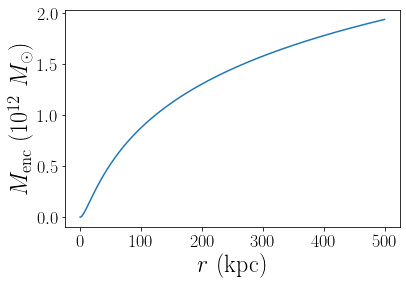

In [6]:
def M_enc(r, c, r_200, v_200):
    """ Mass enclosed given the same parameters as v_c() """
    return ((r*un.kpc)*(v_c(r, c, r_200, v_200)*un.km/un.s)**2 / const.G).to(un.solMass).value
    
M_encs = np.vectorize(M_enc)(rs, c, r_200.value, v_200.value)

print("M_total = %0.2f x 10^12 Solar Masses"%(M_encs[-1]/1e12))

plot(rs, M_encs/1e12)
xlabel(r'$r~\mathrm{(kpc)}$')
ylabel(r'$M_{\rm enc}~(10^{12}~M_\odot)$')
show()

Plot $M(r)$ in little shells (but change the shell size to 0.5 kpc)

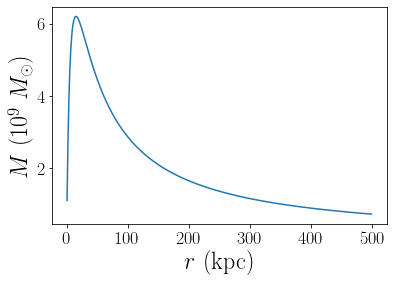

In [7]:
rs = np.arange(0.5, 500, 0.5)
M_encs = np.vectorize(M_enc)(rs, c, r_200.value, v_200.value)

dM_encs = np.diff(M_encs)
# One could also use the full integrator here
# Below is essentially just the midpoint rule
plot((rs[1:]+rs[:-1])/2, dM_encs/1e9) 
xlabel(r'$r~\mathrm{(kpc)}$')
ylabel(r'$M~(10^{9}~M_\odot)$')
show()

Plot $dM(r)/dr$. I am using the `linear_interpolator()` function from HW#1.

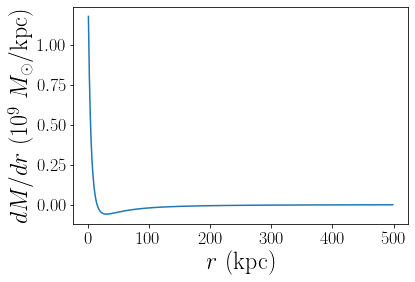

In [8]:
x = (rs[1:]+rs[:-1])/2
y = dM_encs/1e9

func = linear_interpolator(x, y)

N = len(x)
deriv = [0 for i in range(N)]
for i in range(1, N-1):
    deriv[i] = derivative(func, x[i], 0.00001)
    
newx = x[1:-1]
deriv = deriv[1:-1]
    
plot(newx, deriv)
xlabel(r'$r~\mathrm{(kpc)}$')
ylabel(r'$dM/dr~(10^{9}~M_\odot / {\rm kpc})$')
show()